# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Estudo de Caso 1</font>
### <font color='blue'>Previsão de Demanda de Produtos ao Longo do Tempo Para Otimizar Decisões de Logística</font>
### <font color='blue'>Parte 1 - Modelo SARIMAX</font>

![title](imagens/EC1.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Imports
import sklearn
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib : 3.7.1
statsmodels: 0.13.2
numpy      : 1.21.5
sklearn    : 1.2.2
pandas     : 1.4.4



## Carregando os Dados

In [6]:
# Carrega o dataset
dados = pd.read_csv('vc_st_dia_fb.csv', sep=';', index_col='data')
dados.head(3)

,acessos
data,
01/06/2022,74
02/06/2022,129
03/06/2022,189


In [7]:
dados.tail(3)

,acessos
data,
26/02/2023,253
27/02/2023,233
28/02/2023,244


In [9]:
dados.index = pd.to_datetime(dados.index, format='%d/%m/%Y')
dados.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq=None)

In [14]:
# Determinando a frequência como "diária"
dados_ts = dados.asfreq('D')
dados_ts.index

DatetimeIndex(['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
               '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
               '2022-06-09', '2022-06-10',
               ...
               '2023-02-19', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24', '2023-02-25', '2023-02-26',
               '2023-02-27', '2023-02-28'],
              dtype='datetime64[ns]', name='data', length=273, freq='D')

In [16]:
dados_ts.describe()

,acessos
count,273.000000
mean,166.996337
std,111.178794
min,49.000000
25%,111.000000
50%,151.000000
75%,200.000000
max,1543.000000


## Análise Exploratória

Vamos analisar o padrão de itens vendidos ao longo do tempo para a loja 1 e produto 1. Como dica de exercício reproduza este Jupyter Notebook para outras lojas e outros produtos.

([], [])

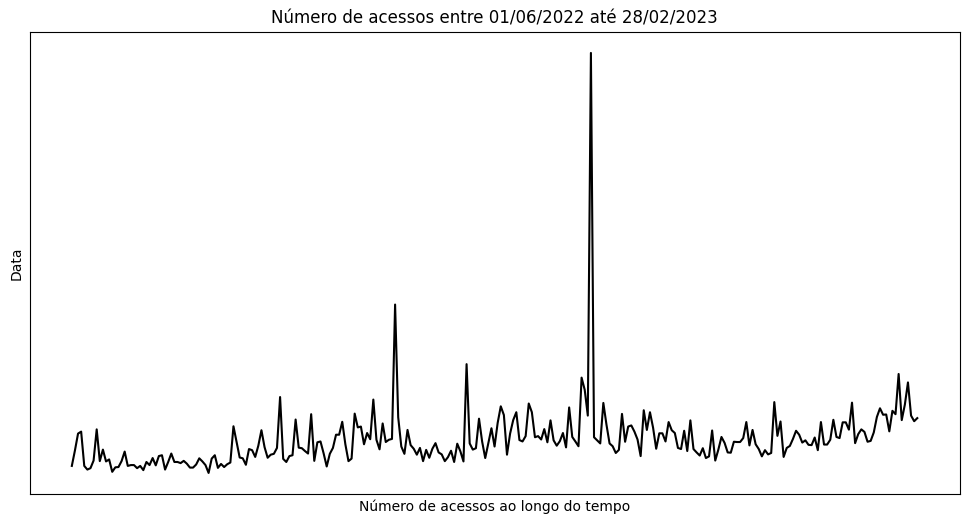

In [17]:
# Plot do comportamento geral da série temporal
plt.figure(figsize = (12,6))
plt.plot(dados_ts, color = 'black')
plt.xlabel('Número de acessos ao longo do tempo')
plt.ylabel('Data')
plt.title("Número de acessos entre 01/06/2022 até 28/02/2023")
plt.xticks([]) 
plt.yticks([]) 

**Análise:**

Observamos um padrão de sazonalidade com picos superiores e inferiores. Vamos analisar outros gráficos em diferentes períodos de tempo.

([], [])

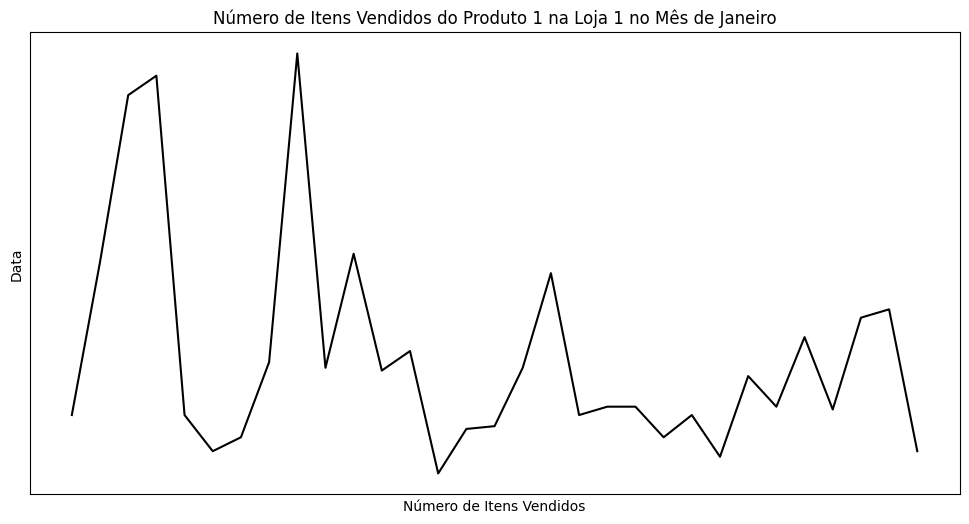

In [18]:
# Plot do comportamento semanal da série temporal (mês de Janeiro com 31 dias)
plt.figure(figsize = (12,6))
plt.plot(dados_ts[:31], color = 'k')
plt.xlabel('Número de Itens Vendidos')
plt.ylabel('Data')
plt.title("Número de Itens Vendidos do Produto 1 na Loja 1 no Mês de Janeiro")
plt.xticks([]) 
plt.yticks([]) 

**Análise:**

Os gráficos confirmam que a série apresenta algum padrão. Vamos decompor a série em seus componentes.

## Decomposição da Série Temporal

**Análise:**

A partir das figuras acima, podemos ver que a série temporal não é estacionária, pois apresenta sazonalidade e uma tendência ascendente.

Para dados estacionários:

* A média da série não deve ser uma função do tempo. A média deve estar perto de uma linha plana horizontal em vez de aumentar ou diminuir ao longo do tempo.
* A variância da série não deve ser função do tempo. Esta propriedade é conhecida como homocedasticidade.
* A covariância da série não deve ser função do tempo.

Também podemos usar o Teste Dickey-Fuller Aumentado para verificar se a série temporal é ou não estacionária.

Para usar modelos ARIMA, a série temporal **DEVE** ser estacionária. Os dados da série temporal devem ser estacionários para remover qualquer correlação óbvia e colinearidade com dados anteriores.

## Estacionaridade

Vamos criar uma função para visualizar a estacionaridade.

In [19]:
# Função para visualizar estacionaridade
def visualiza_estacionaridade(dados_serie):
    
    # Calcula média e desvio padrão móveis 
    rolling_mean = dados_serie.rolling(12).mean()
    rolling_std = dados_serie.rolling(12).std()
    
    # Plot
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(dados_serie, label = 'Acessos')
    mean = plt.plot(rolling_mean, color = 'yellow', label = "Média Móvel")
    std = plt.plot(rolling_std, color = 'green', label = "Desvio Padrão Móvel")
    
    plt.legend(loc = 'best')
    plt.title("Visualizando a Estacionaridade")
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

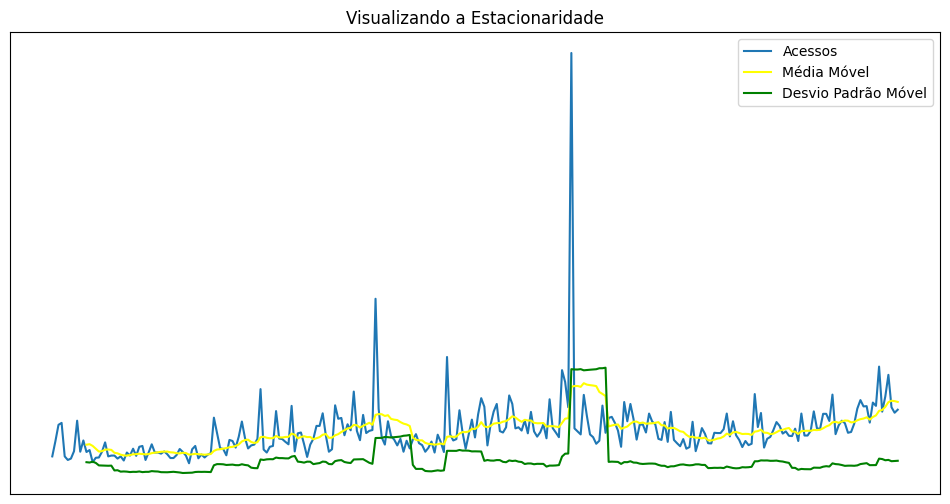

In [20]:
# Aplica a função
visualiza_estacionaridade(dados_ts)

**Análise:**

A série apresenta exatamente o oposto do que precisamos para poder criar um modelo ARIMA. Vamos aplicar um teste estatístico.

### Teste Dickey-Fuller Aumentado

* Um valor-p menor que 0,05 significa que podemos rejeitar a hipótese nula de que os dados da série temporal não são estacionários. Portanto, a série temporal é estacionária.

* Um valor-p maior que 0,05 significa que não rejeitamos a hipótese nula. Portanto, a série temporal não é estacionária.

In [21]:
# Aplica o teste
resultado_adft = adfuller(dados_ts)

In [22]:
resultado_adft

(-5.247982211017449,
 7.011099491050116e-06,
 3,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 3127.7907492760105)

In [23]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


**Análise:**

Como o Teste Dickey-Fuller Aumentado nos deu um valor-p inferior a 0,05, isso significa que a série temporal é estacionária. No entanto, ao observar os gráficos, podemos perceber que há claros indícios de sazonalidade. A média parece ser uma função do tempo, uma vez que flutua com a data.

Como o valor-p não é assim tão baixo (embora seja menor que 0.05), vamos aplicar estacionaridade na série para satisfazer a suposição do modelo ARIMA.

## Estacionarização de Dados de Séries Temporais

### Diferenciação

A diferenciação é uma técnica usada para remover tendências se a série for estacionária em torno de uma tendência.

In [24]:
# Aplica a diferenciação
first_diff = dados_ts.acessos - dados_ts.acessos.shift(1)

In [25]:
# Remove valores NA gerados no processo
first_diff = first_diff.dropna()

([], [])

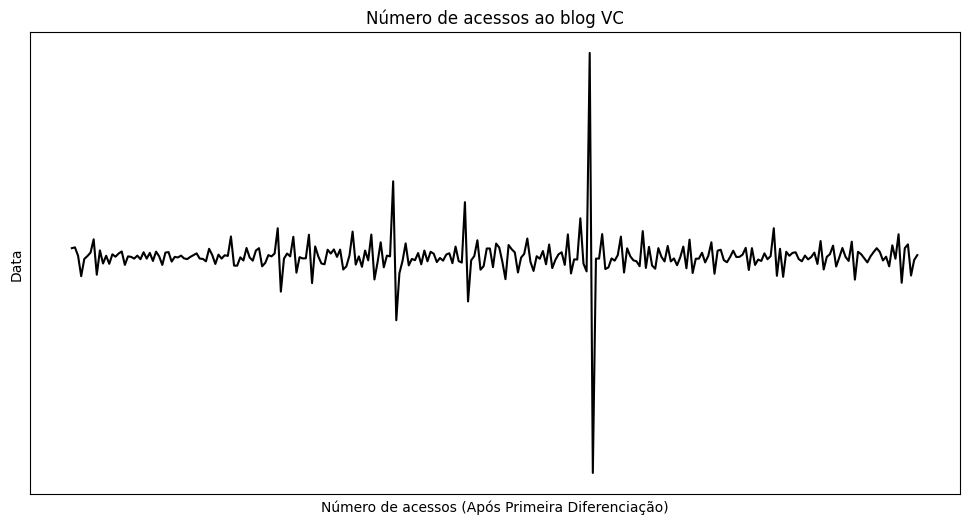

In [26]:
# Plot
plt.figure(figsize = (12,6))
plt.plot(first_diff, color = 'black')
plt.xlabel('Número de acessos (Após Primeira Diferenciação)')
plt.ylabel('Data')
plt.title("Número de acessos ao blog VC")
plt.xticks([]) 
plt.yticks([])

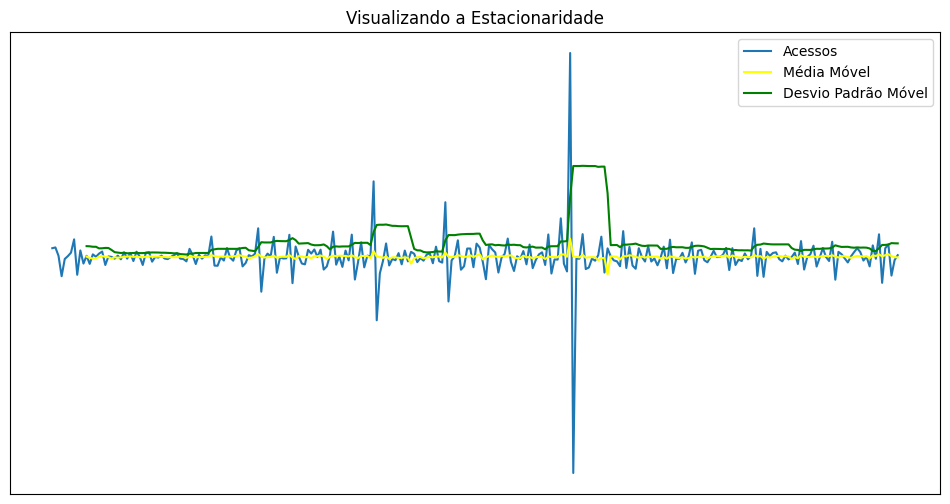

In [27]:
visualiza_estacionaridade(first_diff)

In [28]:
# Aplica o teste
resultado_adft = adfuller(first_diff)

In [29]:
# Valor-p resultado do teste
resultado_adft[1]

6.028358646107165e-12

In [30]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


**Análise:**

Após a primeira diferenciação, podemos ver que a média móvel é uma linha horizontal e não é mais uma função do tempo. Exatamente o que esperamos de uma série para criar um modelo ARIMA.

Além disso, o valor-p obtido no Teste Dickey-Fuller Aumentado é extremamente baixo, praticamente zero. Esta série agora é realmente estacionária.

Podemos então criar nosso modelo ARIMA.

## Modelo SARIMAX

O modelo usado para previsão depende dos dados da série temporal. A série temporal precisa ser dividida para ver se contém ou não partes autorregressivas (AR) e partes de média móvel (MA), integração e sazonalidade.

Os gráficos de função de autocorrelação (ACF) e os gráficos de função de autocorrelação parcial (PACF) podem ser usados para determinar se a série temporal contém partes AR e MA.

Parâmetros que devem ser deifnidos para o modelo SARIMAX:

* p - número de atrasos ou lags (AR)
* d - número de diferenciações necessárias
* q - número de atrasos de erro (MA)
* P - número de atrasos sazonais (AR)
* D - número de diferenças sazonais necessárias
* Q - número de defasagens de erro sazonal (MA)
* S - sazonalidade

### Plots de Autocorrelação (ACF & PACF)

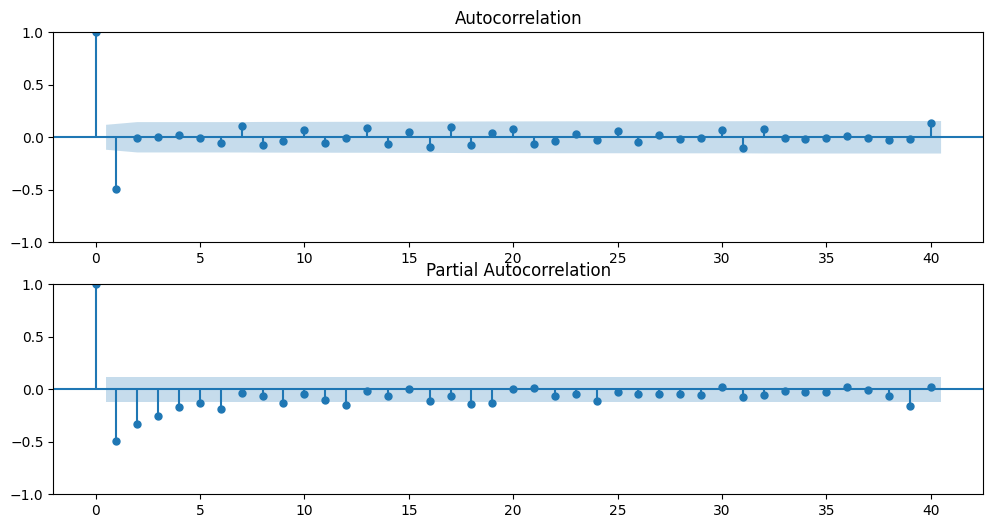

In [31]:
# Plot
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(first_diff, ax = axes[0], lags = 40)
axes[1] = plot_pacf(first_diff, ax = axes[1], lags = 40)

**Análise:**

A partir dos gráficos ACF e PACF, observamos que:

* Esperamos os círculos dentro da área sombreada azul para uma série com comportamento aleatório.


* Existem várias autocorrelações que estão fora da área azul. Isso indica que a série temporal não é totalmente aleatória.


* Há forte correlação em lag = 1, 7, 14, 21, 28, 35 para o gráfico ACF. Ocorre a cada 7 lags.


* Há forte correlação em lag = 1, 2, 3, 4, 5, 6, 13, 20, 27 para gráfico PACF. Ocorre em 6, seguido por atrasos a cada 7, mas diminui.

Com base nessa análise (e outras técnicas) definimos os parâmetros de ordem e ordem sazonal.

Vamos preparar os dados de treino e teste.

In [32]:
# Data limite
cutoff_date = '2023-01-01'

In [33]:
# Prepara datasets de treino e teste
amostra_treino = first_diff.loc[first_diff.index < cutoff_date]
amostra_teste = first_diff.loc[first_diff.index >= cutoff_date]

## Modelagem

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

Precisamos definir a ordem (p,d,q) do modelo para o número de parâmetros AR, diferenciações e parâmetros MA. d deve ser um número inteiro indicando a ordem de integração do processo, enquanto p e q podem ser números inteiros indicando as ordens AR e MA (para que todos os atrasos até essas ordens sejam incluídos) ou então iteráveis fornecendo AR e/ou MA específicos. O padrão é um modelo AR(1): (1,0,0).

Precisamos definir a ordem (P,D,Q,s) do componente sazonal do modelo para os parâmetros AR, diferenciações, parâmetros MA e periodicidade. D deve ser um número inteiro indicando a ordem de integração do processo, enquanto P e Q podem ser números inteiros indicando as ordens AR e MA (para que todos os atrasos até essas ordens sejam incluídos) ou então iteráveis fornecendo AR e/ou MA específicos. s é um inteiro que dá a periodicidade (número de períodos), muitas vezes é 4 para dados trimestrais ou 12 para dados mensais. O padrão é nenhum efeito sazonal.

In [34]:
# Cria o modelo SARIMAX
modelo = SARIMAX(amostra_treino, trend = 'n', order = (6,1,0), seasonal_order = (0,1,1,7))

In [35]:
# Treinamento do modelo
modelo_v1 = modelo.fit(disp = True)

In [36]:
# Previsões com o modelo para janela de 3 meses (meses 10, 11 e 12 de 2017)
previsoes = modelo_v1.predict(start = cutoff_date, end = '2023-02-28', dynamic = False)

In [37]:
# Aplica a diferenciação em teste
first_diff_teste = first_diff
first_diff_teste.index = pd.to_datetime(first_diff_teste.index)

In [43]:
first_diff_teste

data
2022-06-02     55.0
2022-06-03     60.0
2022-06-04      7.0
2022-06-05   -122.0
2022-06-06    -13.0
              ...  
2023-02-24     55.0
2023-02-25     79.0
2023-02-26   -118.0
2023-02-27    -20.0
2023-02-28     11.0
Freq: D, Name: acessos, Length: 272, dtype: float64

Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

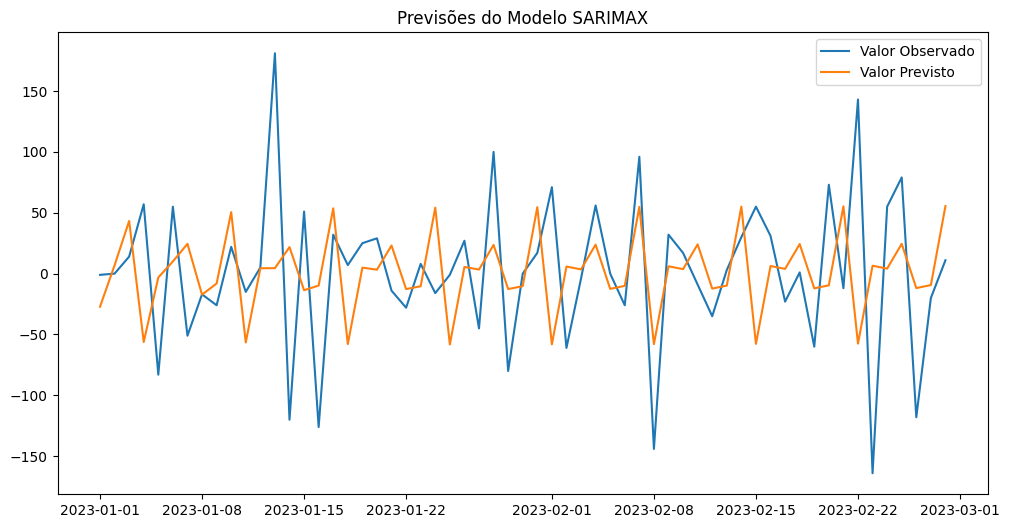

In [38]:
# Plot comparando previsões do modelo para 3 meses, com os dados de teste
fig = plt.figure(figsize = (12,6))
sales = plt.plot(first_diff_teste[cutoff_date:], label = 'Valor Observado')
forecast = plt.plot(previsoes, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

## Avaliação do Modelo

Usaremos o Erro Absoluto Médio (MAE) e o Erro Quadrático Médio (MSE) para avaliar o modelo.

In [39]:
# Erro do modelo - MAE
print('SARIMAX MAE = ', mean_absolute_error(previsoes, amostra_teste))

SARIMAX MAE =  52.591888433988046


In [40]:
# Erro do modelo - MSE
print('SARIMAX MSE = ', mean_squared_error(previsoes, amostra_teste))

SARIMAX MSE =  4784.18755610582


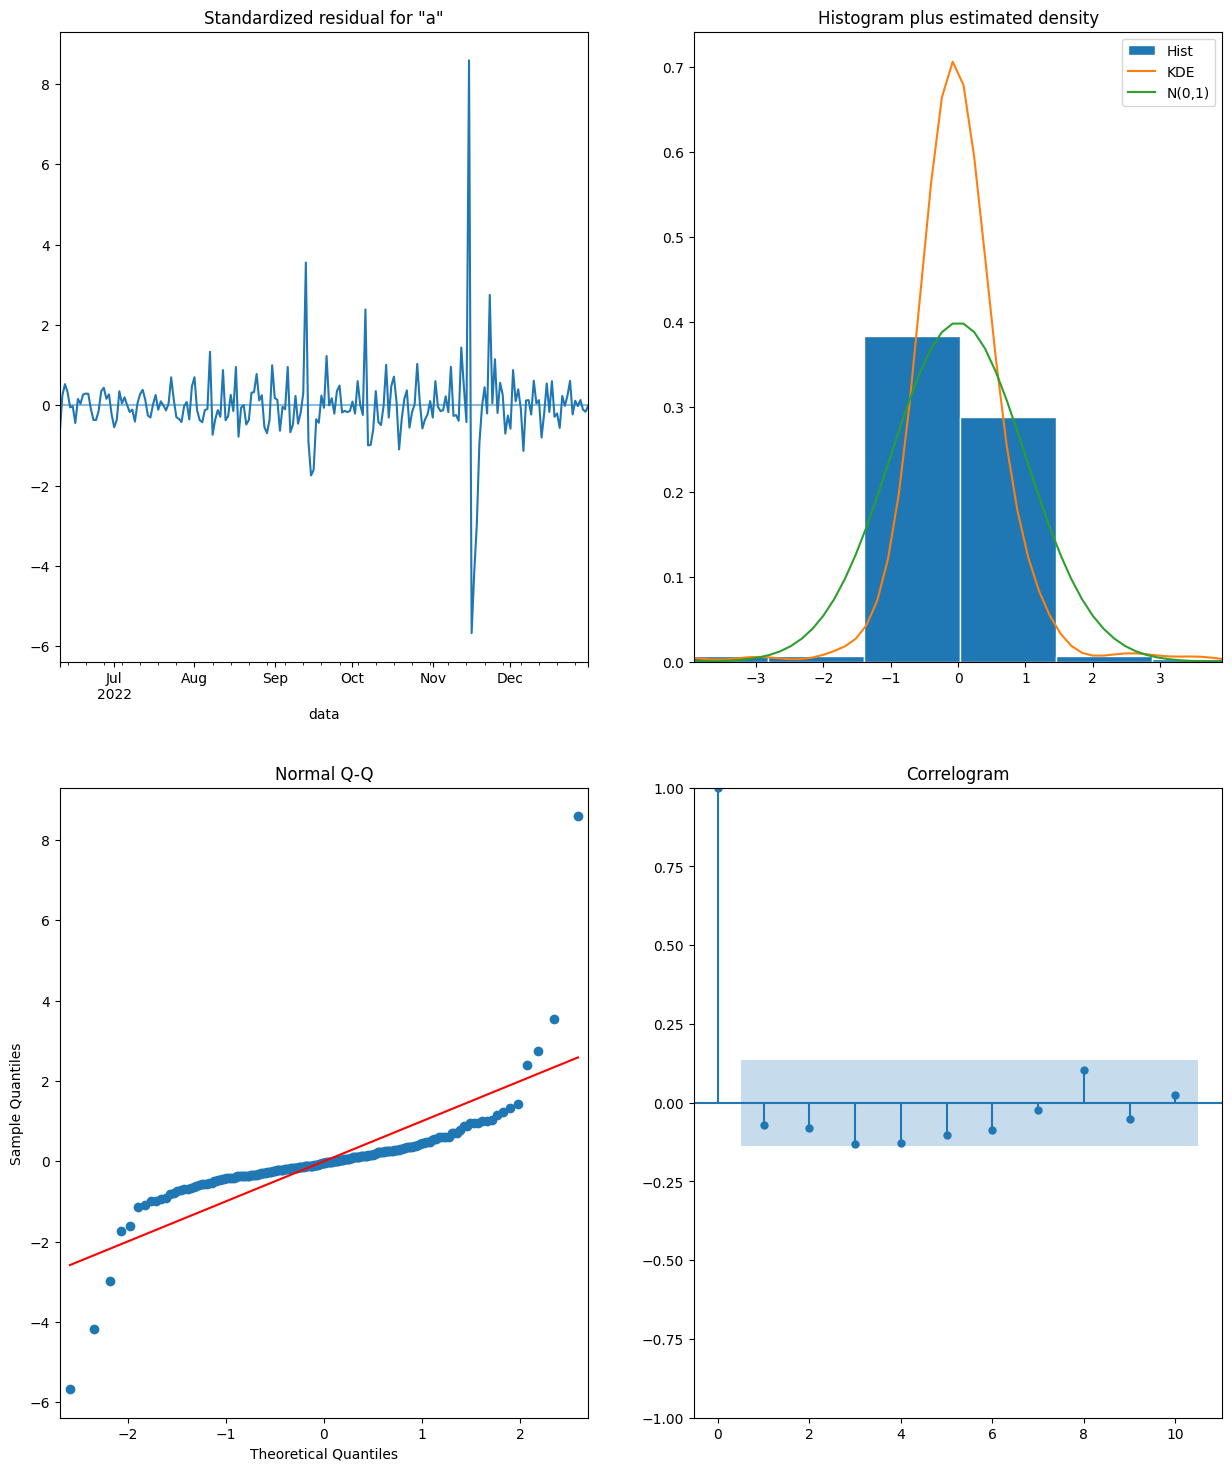

In [41]:
modelo_v1.plot_diagnostics(figsize = (15,18))
plt.show()